# Бэйзлайн беггинга. Случайный лес.

---



## Испорты.

In [26]:
import copy
import random
import warnings

import numpy as np
import pandas as pd
import scipy.stats as sps

from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix, precision_score, recall_score
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

warnings.simplefilter("ignore", DeprecationWarning)
sns.set(context='poster')
%matplotlib inline

np.random.seed(42)

Загрузим наши данные.

In [3]:
train_Mortgage = pd.read_csv('train_Mortgage.csv')
val_Mortgage = pd.read_csv('val_Mortgage.csv')

train_Pension = pd.read_csv('train_Pension.csv')
val_Pension = pd.read_csv('val_Pension.csv')

train_Savings = pd.read_csv('train_Savings.csv')
val_Savings = pd.read_csv('val_Savings.csv')

In [6]:
test = pd.read_csv('unknown_behaviors.csv')
test.head()

,customer_id,age,age_youngest_child,debt_equity,gender,bad_payment,gold_card,pension_plan,household_debt_to_equity_ratio,income,members_in_household,months_current_account,months_customer,call_center_contacts,loan_accounts,number_products,number_transactions,non_worker_percentage,white_collar_percentage,rfm_score
0,44256,38,11,38,1,0,0,0,58,47958.0,4,41,48,2,1,2,1,9,31,7.949
1,46883,30,1,30,0,0,0,0,55,48606.0,2,23,36,2,4,3,2,11,33,11.437
2,32387,41,13,41,1,0,0,0,59,42152.0,4,39,48,1,0,1,1,11,29,7.462
3,25504,42,14,42,1,0,0,0,57,39788.0,3,21,24,2,3,0,0,15,27,0.000
4,35979,42,14,42,1,0,0,0,53,44365.0,6,41,48,3,2,3,1,5,41,7.806


Выделим таргет.

In [8]:
test = test.drop(['customer_id'], axis=1)
feature_columns = test.columns
X_train_Mortgage = train_Mortgage[feature_columns]
y_train_Mortgage = train_Mortgage[['Mortgage']]

X_val_Mortgage = val_Mortgage[feature_columns]
y_val_Mortgage = val_Mortgage[['Mortgage']]

X_train_Pension = train_Pension[feature_columns]
y_train_Pension = train_Pension[['Pension']]

X_val_Pension = val_Pension[feature_columns]
y_val_Pension = val_Pension[['Pension']]

X_train_Savings = train_Savings[feature_columns]
y_train_Savings = train_Savings[['Savings']]

X_val_Savings = val_Savings[feature_columns]
y_val_Savings = val_Savings[['Savings']]

## Функции

In [10]:
def evaluate_binary_classification(y_true, y_predicted, y_probabilities=None, threshold=0.5):
    """
    Оценивает результаты бинарной классификации и выводит метрики и графики.

    Args:
        y_true (array-like): Истинные метки классов (0 или 1).
        y_predicted (array-like): Предсказанные метки классов (0 или 1).  Если переданы вероятности, то предварительно применяем порог к ним.
        y_probabilities (array-like, optional): Предсказанные вероятности принадлежности к классу 1. Defaults to None.
        threshold (float, optional): Порог для определения класса на основе вероятностей. Defaults to 0.5.
    """

    print("=== Binary Classification Evaluation ===")

    cm = confusion_matrix(y_true, y_predicted)
    print("\nConfusion Matrix:")
    print(cm)

    accuracy = accuracy_score(y_true, y_predicted)
    precision = precision_score(y_true, y_predicted)
    recall = recall_score(y_true, y_predicted)
    f1 = f1_score(y_true, y_predicted)

    print(f"\nAccuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    if y_probabilities is not None:

        roc_auc = roc_auc_score(y_true, y_probabilities)
        print(f"\nROC AUC:   {roc_auc:.4f}")

        pr_auc = average_precision_score(y_true, y_probabilities)
        print(f"PR AUC:    {pr_auc:.4f}")

        fpr, tpr, thresholds_roc = roc_curve(y_true, y_probabilities)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic (ROC) Curve")
        plt.legend()
        plt.grid(True)
        plt.show()

        precision, recall, thresholds_pr = precision_recall_curve(y_true, y_probabilities)

        precision = precision[:-1]
        recall = recall[:-1]

        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.2f})")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall (PR) Curve")
        plt.legend()
        plt.grid(True)
        plt.show()

In [11]:
def train_random_forest(X, y, param_grid=None, cv=3, random_state=42):
    """
    Обучает RandomForestClassifier с подбором оптимальных параметров по сетке.

    Args:
        X (pd.DataFrame or np.ndarray): Матрица признаков.
        y (pd.Series or np.ndarray): Вектор целевых переменных.
        param_grid (dict, optional): Сетка параметров для GridSearchCV.
            Если None, используется сетка по умолчанию.
        cv (int, optional): Количество фолдов для кросс-валидации. Defaults to 3.
        random_state (int, optional): Random state для воспроизводимости. Defaults to 42.

    Returns:
        tuple: (best_model, best_params, results)
            best_model: Лучшая обученная модель RandomForestClassifier.
            best_params: Словарь с оптимальными параметрами.
            results:  DataFrame с результатами GridSearchCV.
    """

    if param_grid is None:
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'class_weight': ['balanced', 'balanced_subsample', None]
        }

    rf = RandomForestClassifier(random_state=random_state)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                               cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)

    grid_search.fit(X, y)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    results = pd.DataFrame(grid_search.cv_results_)

    print("\nBest Parameters:")
    print(best_params)

    return best_model, best_params, results

def evaluate_model(model, X_test, y_test):
    """Оценивает обученную модель на тестовых данных."""
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    evaluate_binary_classification(y_test, y_pred)

    print("\nClassification Report:")
    print(report)

    return y_pred

In [12]:
def visualize_feature_importance(model, feature_names):
    """Визуализирует важность признаков с улучшениями."""
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize=(10, 7))
    plt.title('Feature Importances', fontsize=16)
    plt.barh(range(len(indices)), importances[indices], color="#66b3ff", align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=10)
    plt.xlabel('Relative Importance', fontsize=12)
    plt.xlim(0, np.max(importances) * 1.1)
    plt.tight_layout()
    sns.despine()
    plt.show()

def visualize_predictions(y_true, y_pred, class_names=None):
   """Визуализирует предсказанные и истинные значения."""
   cm = confusion_matrix(y_true, y_pred)
   plt.figure(figsize=(8, 6))
   sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
               xticklabels=class_names if class_names else ['Class 0', 'Class 1'],
               yticklabels=class_names if class_names else ['Class 0', 'Class 1'])
   plt.xlabel("Predicted Label")
   plt.ylabel("True Label")
   plt.title("Confusion Matrix")
   plt.show()

In [18]:
def roc_auc(model, X_test, y_test):

    y_pred_proba = model.predict_proba(X_test)[:, 1] # Вероятности для класса 1
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC: {roc_auc}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')

## Признак `Mortgage`.

Обучаем модель.

In [13]:
mortgage_model, mortgage_params, mortgage_results = train_random_forest(X_train_Mortgage, y_train_Mortgage)
mortgage_model_pred = evaluate_model(mortgage_model, X_val_Mortgage, y_val_Mortgage)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Best Parameters:
{'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
=== Binary Classification Evaluation ===

Confusion Matrix:
[[317  16]
 [146 187]]

Accuracy:  0.7568
Precision: 0.9212
Recall:    0.5616
F1 Score:  0.6978

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.95      0.80       333
           1       0.92      0.56      0.70       333

    accuracy                           0.76       666
   macro avg       0.80      0.76      0.75       666
weighted avg       0.80      0.76      0.75       666



~ 12 min

Строим столбчатую диаграмму.

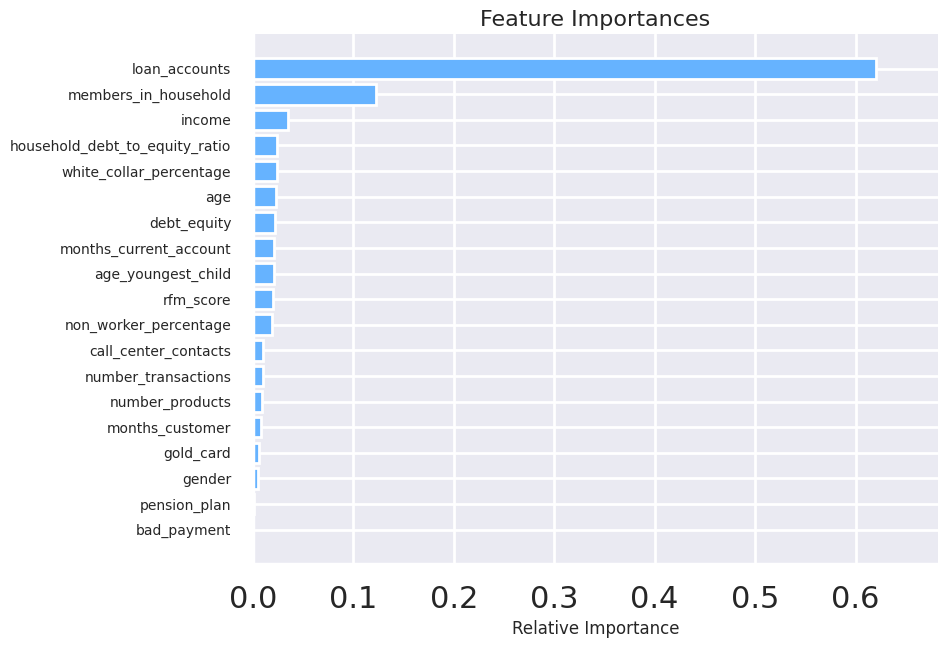

In [15]:
visualize_feature_importance(mortgage_model, X_train_Mortgage.columns)

Видим, что важность признака `loan_accounts` сильно превосходит важность остальных признаков. Как мне кажется, это вероятно так и должно быть, поэтому надо будет в будущем проверить, так ли это.

Также видим, что категориальные признаки болтаются в конце диаграммы, это не очень хорошо. Это все говорит, что признаки все же нужно обработать, например как я предложила выше.

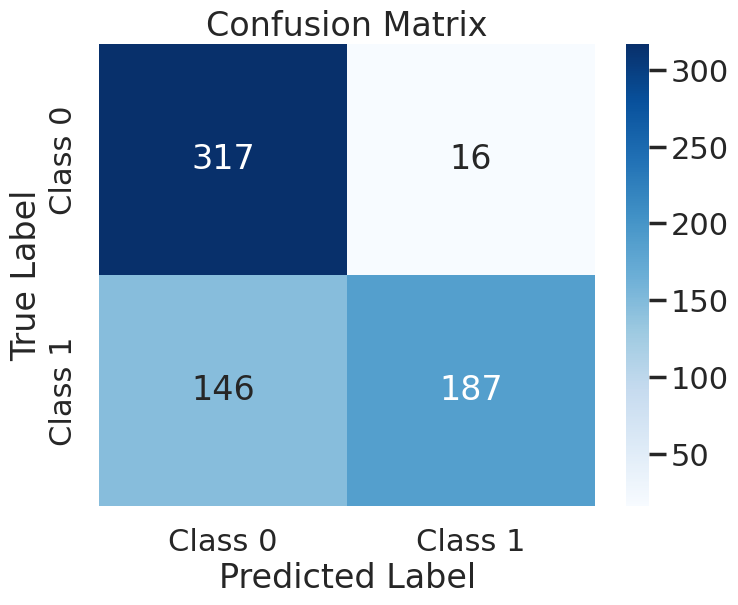

In [16]:
visualize_predictions(y_val_Mortgage, mortgage_model_pred)

По матрице можно сказать, что разница в количестве `FN` и `TN` очень невелика, это очень плохо. Так что с этим тоже надо что-то делать.

### Кривая ROC-AUC.

AUC: 0.9370676983289596


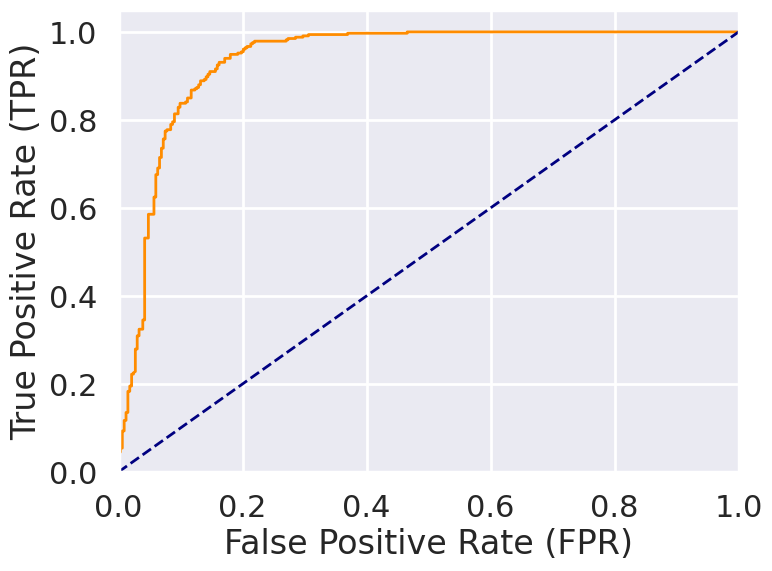

In [19]:
roc_auc(mortgage_model, X_val_Mortgage, y_val_Mortgage)

Значение auc получилось очень хорошее, мы решили взять эту метрику как основную.

### Выводы.

**Выводы:** самым важным признаком оказался `loan_accounts`, другие признакики значительно от него отстают. Метрика получилась очень хорошей, но похуже, чем в `CatBoost`.

## Признак Pension.

Обучим модель с оптимальными параметрами.

In [20]:
pension_model, pension_params, pension_results = train_random_forest(X_train_Pension, y_train_Pension)
pension_model_pred = evaluate_model(pension_model, X_val_Pension, y_val_Pension)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Best Parameters:
{'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
=== Binary Classification Evaluation ===

Confusion Matrix:
[[477  14]
 [436  55]]

Accuracy:  0.5418
Precision: 0.7971
Recall:    0.1120
F1 Score:  0.1964

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.97      0.68       491
           1       0.80      0.11      0.20       491

    accuracy                           0.54       982
   macro avg       0.66      0.54      0.44       982
weighted avg       0.66      0.54      0.44       982



Посмотрим на важность признаков.

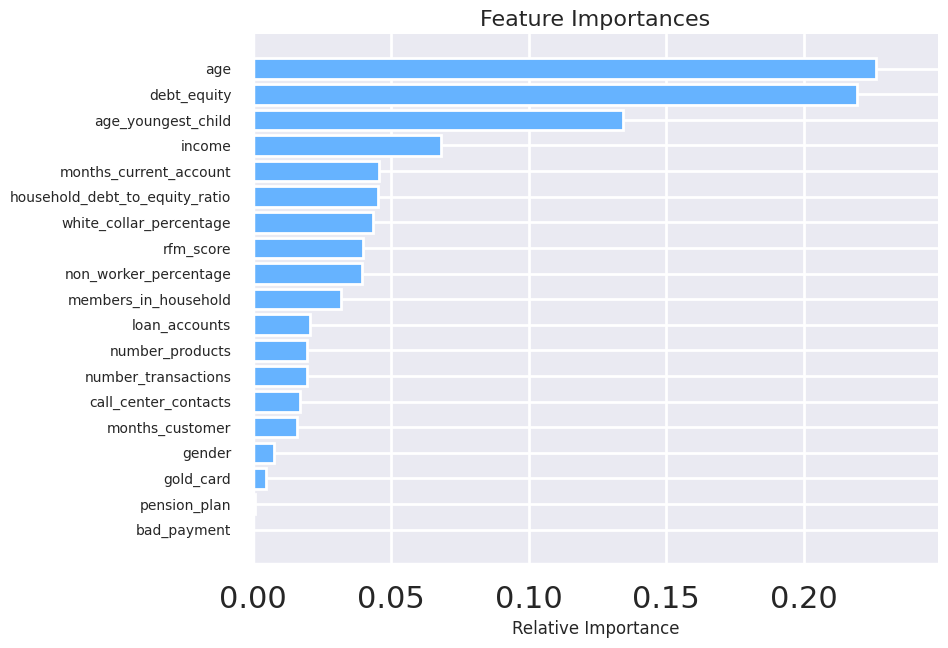

In [21]:
visualize_feature_importance(pension_model, X_train_Pension.columns)

### Кривая ROC-AUC.

Построим ROC-AUC.

AUC: 0.7686669625561533


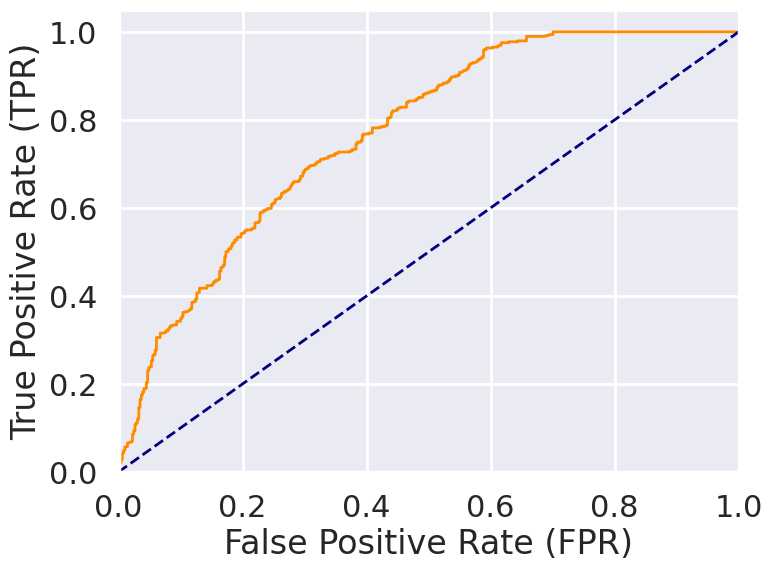

In [22]:
roc_auc(pension_model, X_val_Pension, y_val_Pension)

### Выводы.

**Выводы:** опять наблюдается почти нулевая важность категориальных признаков, при этом лидирующих стало больше. Как будто возраст и правда должен сильно влиять на склонность к пенсионному продукту, раньше я также подметила связь возраста клиента и его младшего ребенка, тут мы видим очередное подтверждение этой теории. Метрика получилась сильно хуже, чем по ипотеке, значит будем улучшать модель или пробовать другие методы.

## Признак Savings.

Делаем все то же самое.

In [23]:
savings_model, savings_params, savings_results = train_random_forest(X_train_Savings, y_train_Savings)
savings_model_pred = evaluate_model(savings_model, X_val_Savings, y_val_Savings)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Best Parameters:
{'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
=== Binary Classification Evaluation ===

Confusion Matrix:
[[746  99]
 [631 214]]

Accuracy:  0.5680
Precision: 0.6837
Recall:    0.2533
F1 Score:  0.3696

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.88      0.67       845
           1       0.68      0.25      0.37       845

    accuracy                           0.57      1690
   macro avg       0.61      0.57      0.52      1690
weighted avg       0.61      0.57      0.52      1690



Важность признаков.

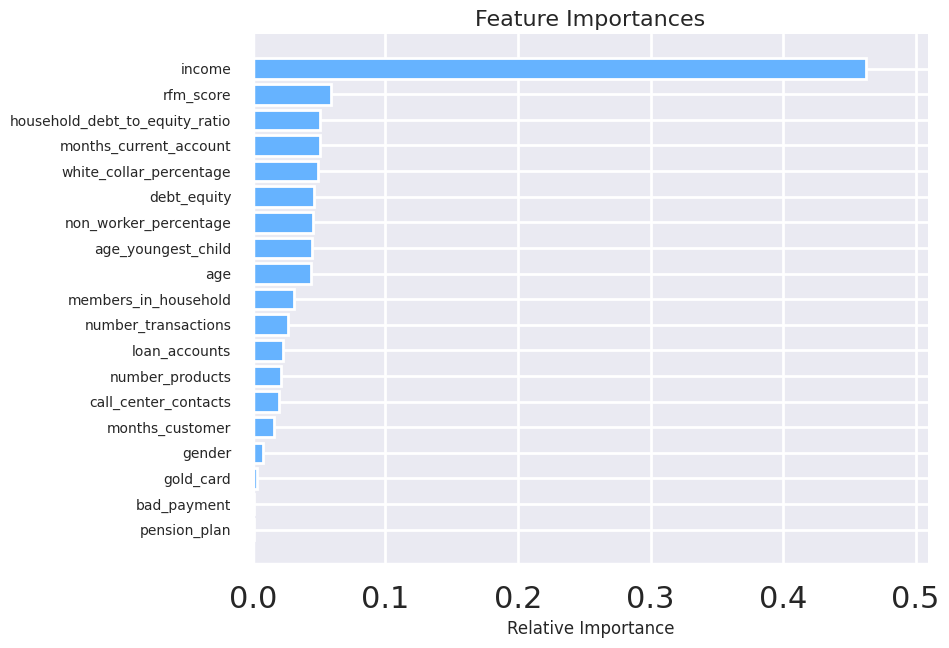

In [24]:
visualize_feature_importance(savings_model, X_train_Savings.columns)

### Кривая ROC-AUC.

Метрика.

AUC: 0.682565036238227


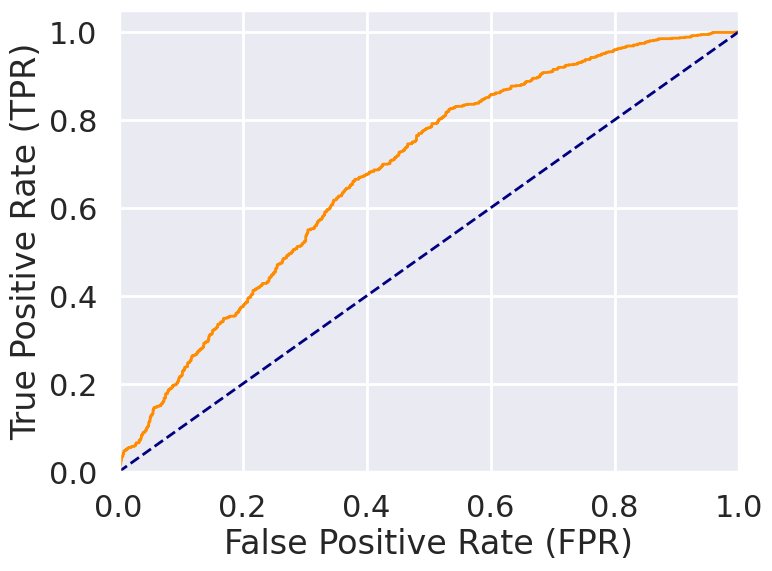

In [25]:
roc_auc(savings_model, X_val_Savings, y_val_Savings)

### Выводы.

**Выводы:** ожидаемо самый важный признак это доход, та же история с категориальными признаками и значение метрики еще хуже. Так что тут тоже стоит рассотреть другие модели или поработать с признаками.

# Обработка аномалий с `Isolation Forest`.

---


Теперь мы будем искать аномалии в тренировочных данных и обучаться на выборке без них, а потом сравним результат с обучением обычного случайного леса.

## Признак `Mortgage`.

Обучим модель.

In [27]:
isol_mortgage_model = IsolationForest(n_estimators=100, random_state=42, contamination='auto')
isol_mortgage_model.fit(X_train_Mortgage, y_train_Mortgage)

IsolationForest(random_state=42)

Получим предсказания аномальности.

In [28]:
mortgage_model_isol_pred = isol_mortgage_model.predict(X_train_Mortgage)
mortgage_model_isol_scores = isol_mortgage_model.decision_function(X_train_Mortgage) #Оценки аномальности
mortgage_model_isol_scores

array([ 0.06270926,  0.07647077,  0.02155996, ..., -0.02303753,
        0.08743041,  0.06288328])

Отрисуем на графике.

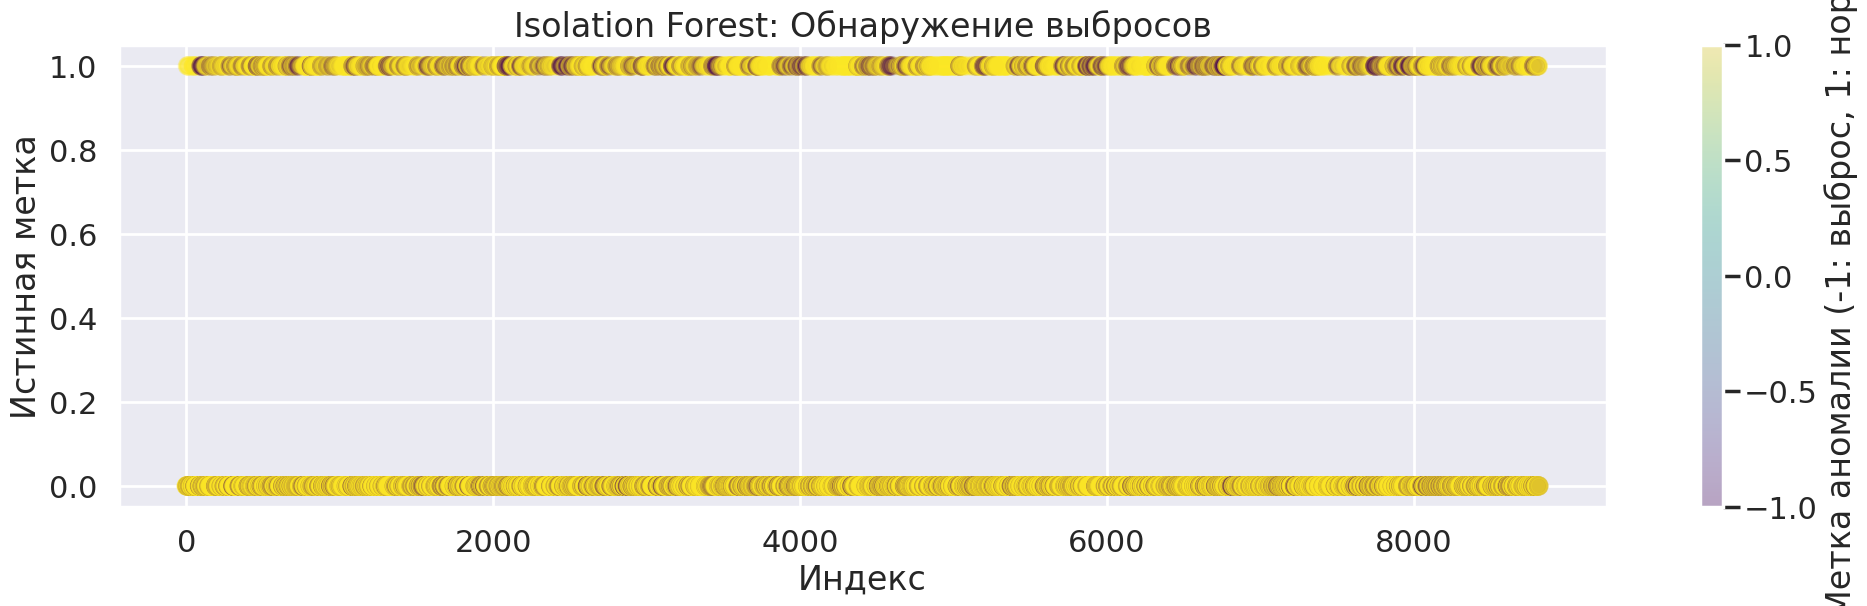

In [29]:
plt.figure(figsize=(24, 6))
plt.scatter(y=y_train_Mortgage, x=X_train_Mortgage.index, c=mortgage_model_isol_pred, cmap='viridis', alpha=0.3)
plt.title('Isolation Forest: Обнаружение выбросов')
plt.xlabel('Индекс')
plt.ylabel('Истинная метка')
plt.colorbar(label='Метка аномалии (-1: выброс, 1: норма)')
plt.show()

Выбросов довольно много... Но попробуем их отсечь.

In [30]:
X_train_Mortgage['is_anomaly'] = mortgage_model_isol_pred
X_train_Mortgage['is_anomaly'] = X_train_Mortgage['is_anomaly'].map({1: 0, -1: 1})

y_train_Mortgage['is_anomaly'] = mortgage_model_isol_pred
y_train_Mortgage['is_anomaly'] = y_train_Mortgage['is_anomaly'].map({1: 0, -1: 1})

<ipython-input-30-87796ef08963>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_Mortgage['is_anomaly'] = mortgage_model_isol_pred
<ipython-input-30-87796ef08963>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_Mortgage['is_anomaly'] = y_train_Mortgage['is_anomaly'].map({1: 0, -1: 1})


Отсекаем хорошую часть данных.

In [31]:
X_train_Mortgage_isol = X_train_Mortgage[X_train_Mortgage['is_anomaly'] == 0]
y_train_Mortgage_isol = y_train_Mortgage[y_train_Mortgage['is_anomaly'] == 0]

Убираем лишнюю колонку из данных.

In [32]:
X_train_Mortgage_isol = X_train_Mortgage_isol.drop(['is_anomaly'], axis=1)
y_train_Mortgage_isol = y_train_Mortgage_isol.drop(['is_anomaly'], axis=1)

Обучаем случайный лес на данных без аномалий.

In [33]:
mortgage_model_isol, mortgage_params_isol, mortgage_results_isol = train_random_forest(X_train_Mortgage_isol, y_train_Mortgage_isol)
mortgage_model_pred_isol = evaluate_model(mortgage_model_isol, X_val_Mortgage, y_val_Mortgage)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Best Parameters:
{'class_weight': None, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
=== Binary Classification Evaluation ===

Confusion Matrix:
[[317  16]
 [154 179]]

Accuracy:  0.7447
Precision: 0.9179
Recall:    0.5375
F1 Score:  0.6780

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.95      0.79       333
           1       0.92      0.54      0.68       333

    accuracy                           0.74       666
   macro avg       0.80      0.74      0.73       666
weighted avg       0.80      0.74      0.73       666



Важность признаков.

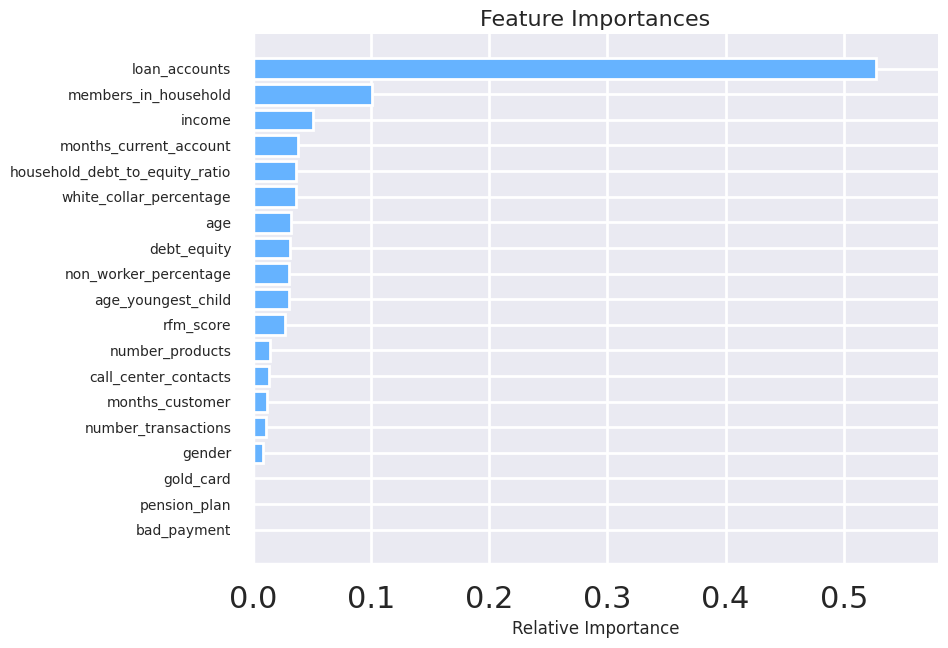

In [34]:
visualize_feature_importance(mortgage_model_isol, X_train_Mortgage_isol.columns)

### Кривая ROC-AUC.

AUC: 0.9371578785993199


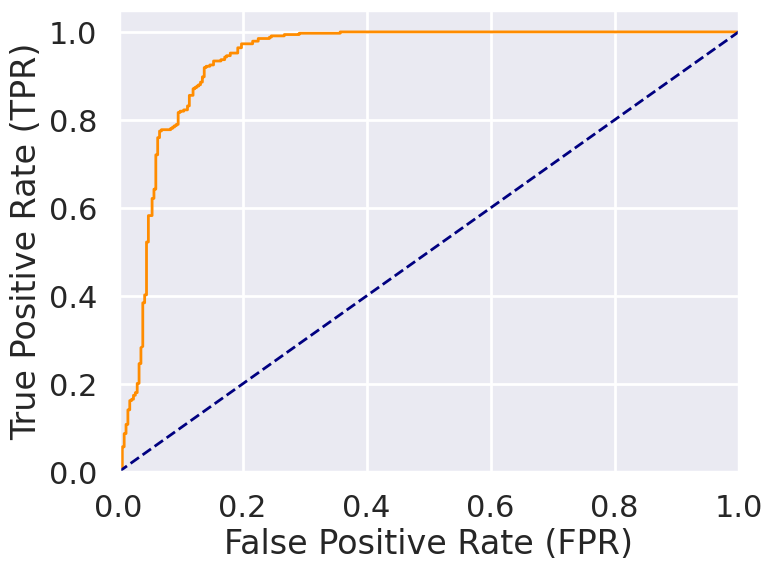

In [35]:
roc_auc(mortgage_model_isol, X_val_Mortgage, y_val_Mortgage)

**Вывод:** получили увеличение AUC на 0.0001 XD

## Признак `Pension`.

In [36]:
isol_pension_model = IsolationForest(n_estimators=100, random_state=42, contamination='auto')
isol_pension_model.fit(X_train_Pension, y_train_Pension)

IsolationForest(random_state=42)

Аномалии.

In [37]:
pension_model_isol_pred = isol_pension_model.predict(X_train_Pension)
pension_model_isol_scores = isol_mortgage_model.decision_function(X_train_Pension) #Оценки аномальности
pension_model_isol_scores

array([ 0.03635954,  0.01823396, -0.0707899 , ..., -0.06080264,
        0.04830408,  0.0346265 ])

Визуализация.

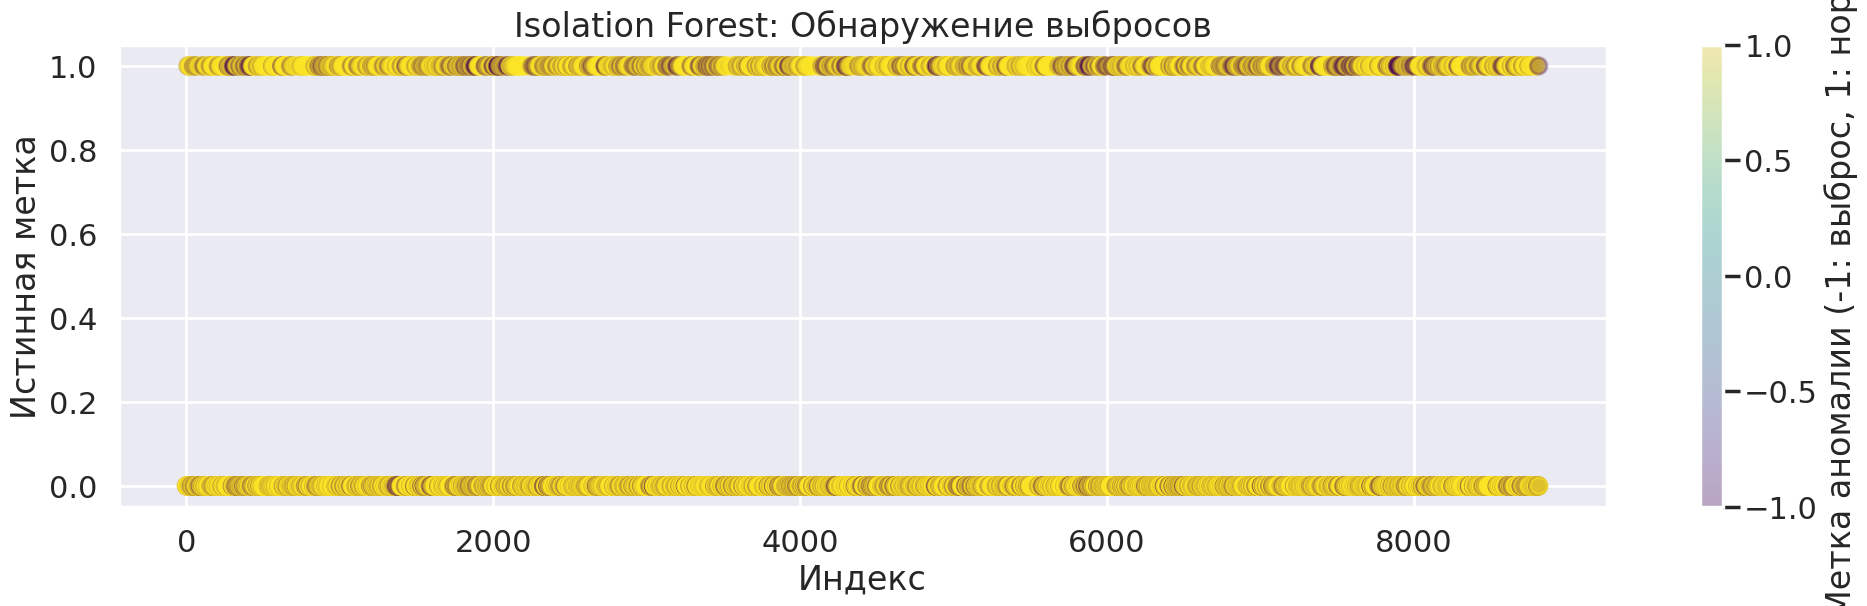

In [38]:
plt.figure(figsize=(24, 6))
plt.scatter(y=y_train_Pension, x=X_train_Pension.index, c=pension_model_isol_pred, cmap='viridis', alpha=0.3)
plt.title('Isolation Forest: Обнаружение выбросов')
plt.xlabel('Индекс')
plt.ylabel('Истинная метка')
plt.colorbar(label='Метка аномалии (-1: выброс, 1: норма)')
plt.show()

Убираем аномалии из данных.

In [39]:
X_train_Pension['is_anomaly'] = pension_model_isol_pred
X_train_Pension['is_anomaly'] = X_train_Pension['is_anomaly'].map({1: 0, -1: 1})

y_train_Pension['is_anomaly'] = pension_model_isol_pred
y_train_Pension['is_anomaly'] = y_train_Pension['is_anomaly'].map({1: 0, -1: 1})


X_train_Pension_isol = X_train_Pension[X_train_Pension['is_anomaly'] == 0]
y_train_Pension_isol = y_train_Pension[y_train_Pension['is_anomaly'] == 0]

X_train_Pension_isol = X_train_Pension_isol.drop(['is_anomaly'], axis=1)
y_train_Pension_isol = y_train_Pension_isol.drop(['is_anomaly'], axis=1)

<ipython-input-39-3d344bf4d23f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_Pension['is_anomaly'] = pension_model_isol_pred
<ipython-input-39-3d344bf4d23f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_Pension['is_anomaly'] = y_train_Pension['is_anomaly'].map({1: 0, -1: 1})


Обучаем случайный лес.

In [40]:
pension_model_isol, pension_params_isol, pension_results_isol = train_random_forest(X_train_Pension_isol, y_train_Pension_isol)
pension_model_pred_isol = evaluate_model(pension_model_isol, X_val_Pension, y_val_Pension)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Best Parameters:
{'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
=== Binary Classification Evaluation ===

Confusion Matrix:
[[481  10]
 [427  64]]

Accuracy:  0.5550
Precision: 0.8649
Recall:    0.1303
F1 Score:  0.2265

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.98      0.69       491
           1       0.86      0.13      0.23       491

    accuracy                           0.55       982
   macro avg       0.70      0.55      0.46       982
weighted avg       0.70      0.55      0.46       982



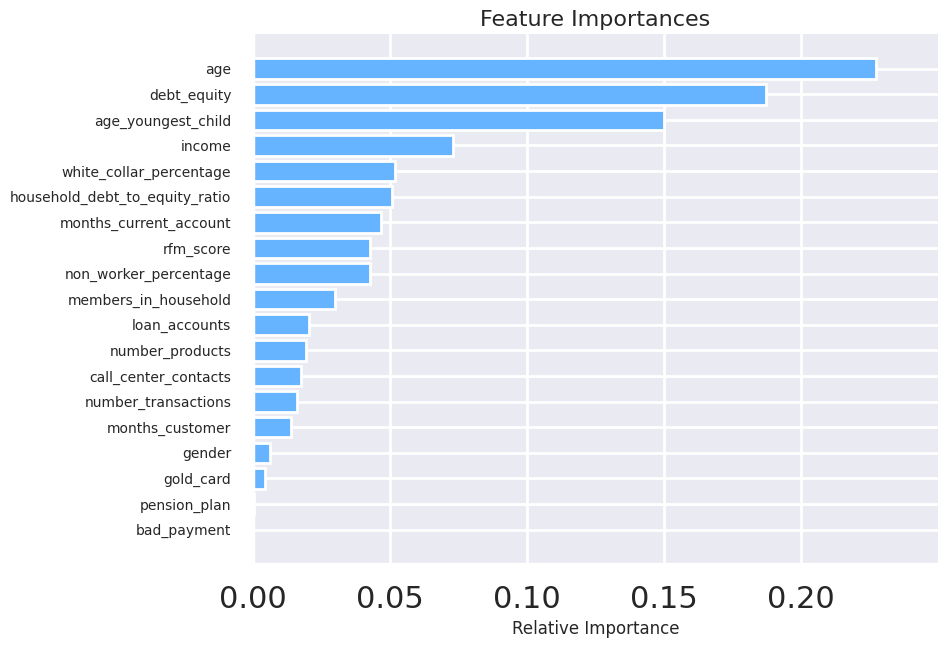

In [41]:
visualize_feature_importance(pension_model_isol, X_train_Pension_isol.columns)

### Кривая ROC-AUC.

AUC: 0.7625569829227521


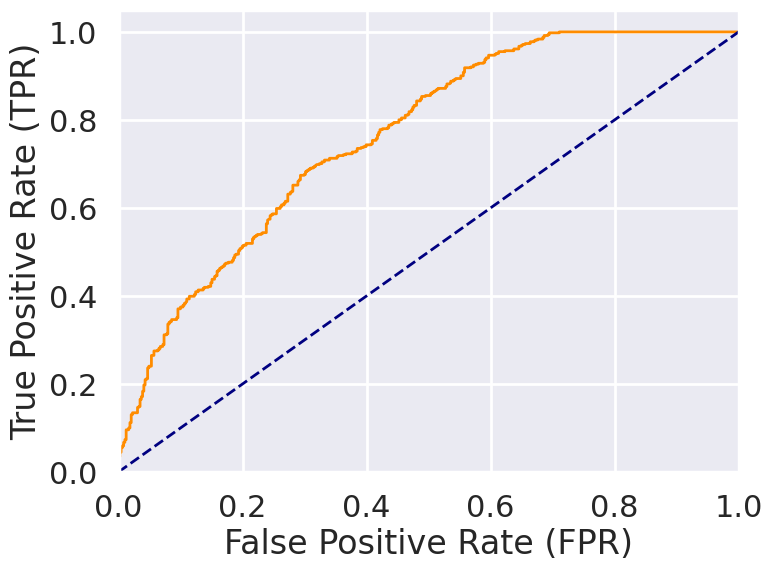

In [42]:
roc_auc(pension_model_isol, X_val_Pension, y_val_Pension)

**Вывод:** значение AUC уменьшилось...

## Признак `Savings`.

In [43]:
isol_savings_model = IsolationForest(n_estimators=100, random_state=42, contamination='auto')
isol_savings_model.fit(X_train_Savings, y_train_Savings)

IsolationForest(random_state=42)

Ищем аномалии.

In [44]:
savings_model_isol_pred = isol_savings_model.predict(X_train_Savings)
savings_model_isol_scores = isol_mortgage_model.decision_function(X_train_Savings) #Оценки аномальности
savings_model_isol_scores

array([0.09269325, 0.04876509, 0.05464313, ..., 0.06309233, 0.0325424 ,
       0.06570525])

Визуализируем аномальность.

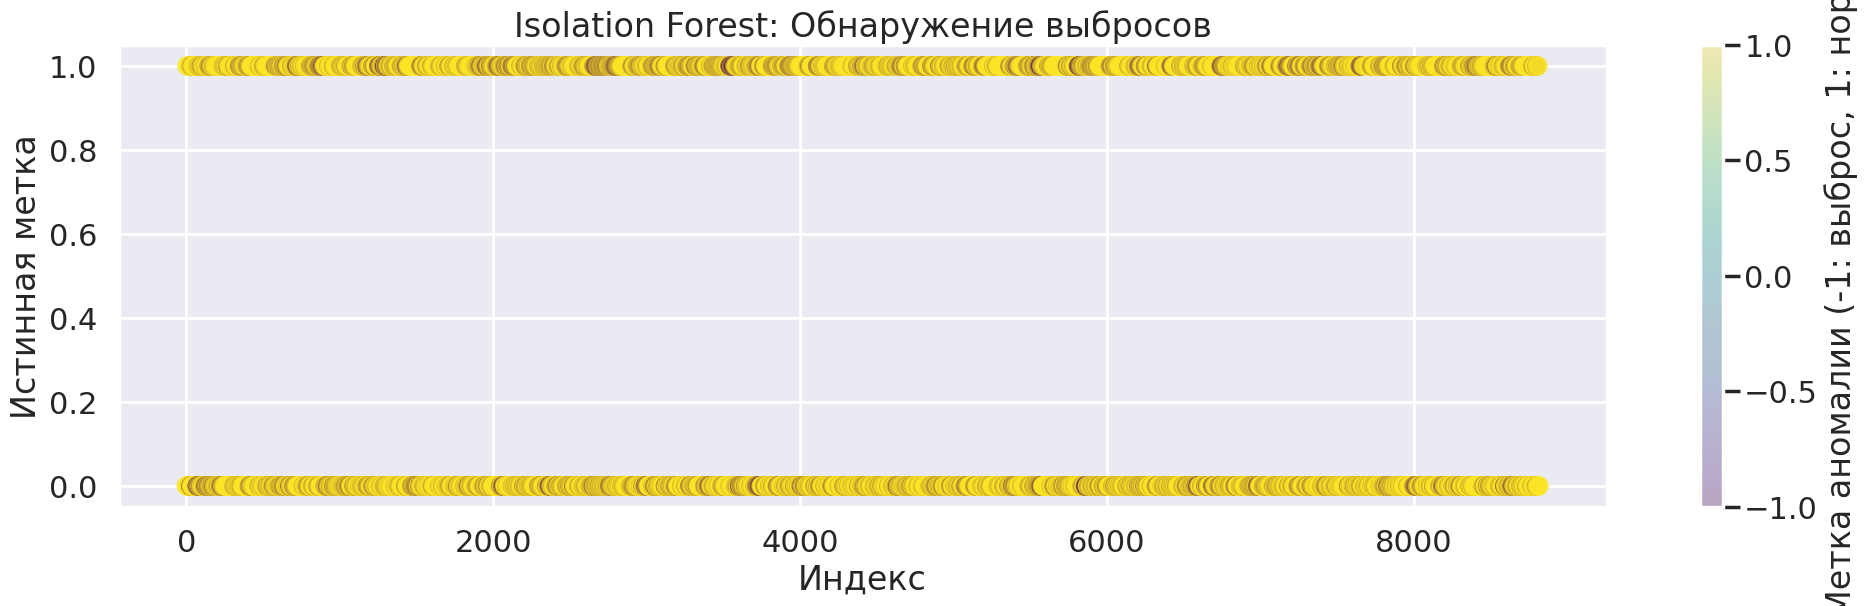

In [45]:
plt.figure(figsize=(24, 6))
plt.scatter(y=y_train_Savings, x=X_train_Savings.index, c=savings_model_isol_pred, cmap='viridis', alpha=0.3)
plt.title('Isolation Forest: Обнаружение выбросов')
plt.xlabel('Индекс')
plt.ylabel('Истинная метка')
plt.colorbar(label='Метка аномалии (-1: выброс, 1: норма)')
plt.show()

Убираем аномалии из данных.

In [46]:
X_train_Savings['is_anomaly'] = savings_model_isol_pred
X_train_Savings['is_anomaly'] = X_train_Savings['is_anomaly'].map({1: 0, -1: 1})

y_train_Savings['is_anomaly'] = savings_model_isol_pred
y_train_Savings['is_anomaly'] = y_train_Savings['is_anomaly'].map({1: 0, -1: 1})


X_train_Savings_isol = X_train_Savings[X_train_Savings['is_anomaly'] == 0]
y_train_Savings_isol = y_train_Savings[y_train_Savings['is_anomaly'] == 0]

X_train_Savings_isol = X_train_Savings_isol.drop(['is_anomaly'], axis=1)
y_train_Savings_isol = y_train_Savings_isol.drop(['is_anomaly'], axis=1)

<ipython-input-46-809cc78532eb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_Savings['is_anomaly'] = savings_model_isol_pred
<ipython-input-46-809cc78532eb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_Savings['is_anomaly'] = y_train_Savings['is_anomaly'].map({1: 0, -1: 1})


Обучаем случайный лес.

In [47]:
savings_model_isol, savings_params_isol, savings_results_isol = train_random_forest(X_train_Savings_isol, y_train_Savings_isol)
savings_model_pred_isol = evaluate_model(savings_model_isol, X_val_Savings, y_val_Savings)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Best Parameters:
{'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
=== Binary Classification Evaluation ===

Confusion Matrix:
[[732 113]
 [599 246]]

Accuracy:  0.5787
Precision: 0.6852
Recall:    0.2911
F1 Score:  0.4086

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.87      0.67       845
           1       0.69      0.29      0.41       845

    accuracy                           0.58      1690
   macro avg       0.62      0.58      0.54      1690
weighted avg       0.62      0.58      0.54      1690



Важность признаков.

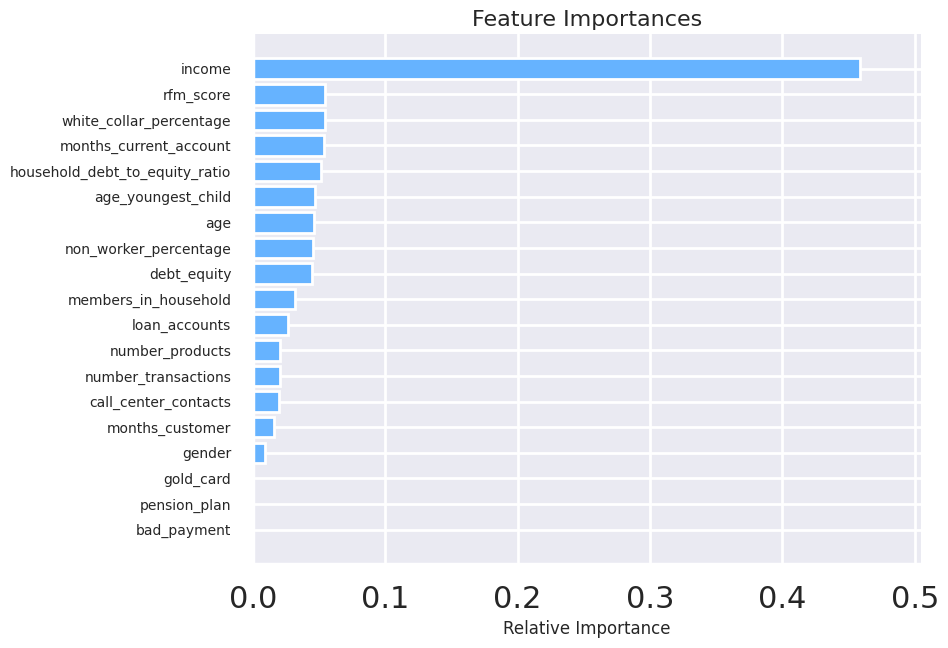

In [48]:
visualize_feature_importance(savings_model_isol, X_train_Savings_isol.columns)

### Кривая ROC-AUC.

AUC: 0.6822877350232835


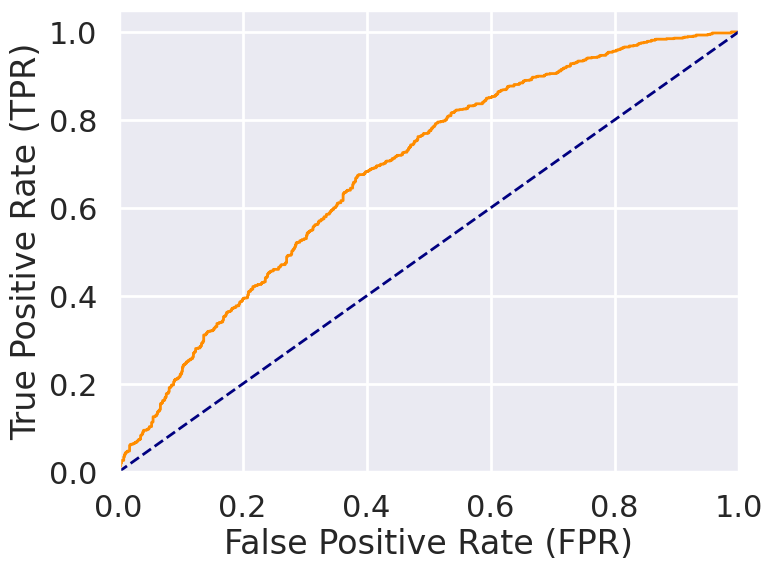

In [49]:
roc_auc(savings_model_isol, X_val_Savings, y_val_Savings)

**Вывод:** тут тоже получили ухудшение.

## Выводы.

Для двух из трех признаков показатели только ухужшились, так что удаление аномалий - плохая стратегия для решения посавленной задачи. При этом, все зависит от модели, так что возможно имеет смысл проверить эту стратегию на других методах.